In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
import numpy as np
from torch.utils.data import Dataset
import torch.nn.functional as F

from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/projfinal/

Mounted at /content/drive
/content/drive/MyDrive/projfinal


In [2]:
import numpy as np
import skimage
import skimage.io as skio
import scipy.signal as signal
import matplotlib
from matplotlib import pyplot as plt
import cv2

In [166]:
from skimage.transform import rescale, resize, downscale_local_mean

img1 = skio.imread('buildings.jpeg')
img2 = skio.imread('starry_night.jpeg')
img2 = resize(img2, (img1.shape[0], img1.shape[1]), anti_aliasing=True)

In [4]:
assert img1.shape == img2.shape

In [5]:
img1.shape

(768, 1024, 3)

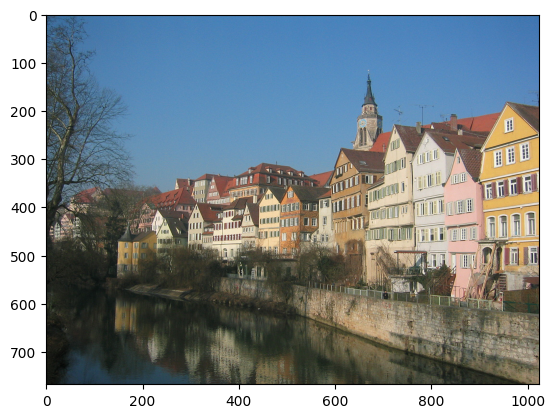

In [ ]:
plt.imshow(img1)

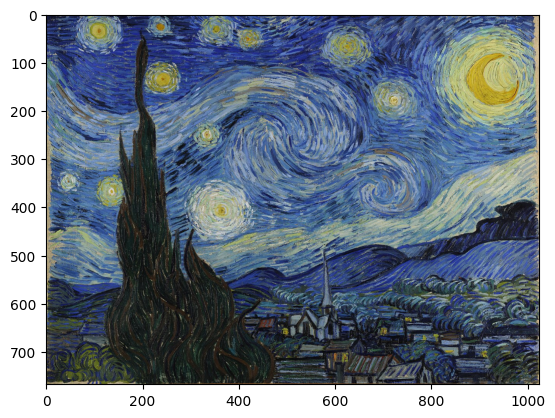

In [ ]:
plt.imshow(img2)

In [ ]:
# model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg19', pretrained=True)
# model.eval()

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:04<00:00, 121MB/s] 


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [ ]:
# from torchvision.models import vgg19, VGG19_Weights
# vgg = vgg19(weights=VGG19_Weights.DEFAULT).features.eval()

In [167]:
from torchvision import models
model = models.vgg19(weights=models.VGG19_Weights.DEFAULT).features.eval()

In [ ]:
model

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [168]:
for p in model.parameters():
  p.requires_grad = False

In [169]:
class ContentLoss(nn.Module):
  def forward(self, input, target):
      # loss = F.mse_loss(target.clone(), input)
      loss = torch.mean((input - target)**2)
      return loss

In [170]:
def gram_matrix(input):
  # batch size, feature_map dim, h, w of feature_map
  b, c, d = input.shape

  # resize features
  features = input.view(b, c * d)

  # gram matrix is X @ X.T
  G = torch.mm(features, features.t())

  # return G.div(b * (c * d)**2)
  return G

In [171]:
class StyleLoss(nn.Module):
  def forward(self, input, target):
    A = gram_matrix(input.clone())
    G = gram_matrix(target)
    b, cd = A.shape
    # loss = F.mse_loss(G, A) / (b * cd)
    loss = torch.sum((G - A)**2) / (4 * b**2 * cd**2)
    return loss


In [172]:
class StyleModel(nn.Module):
  def __init__(self, content_img, content_loss, style_loss, content_layers, style_layers):
    super(StyleModel, self).__init__()
    self.input_img = nn.Parameter(torch.rand(content_img.data.size()))
    self.content_loss = content_loss
    self.style_loss = style_loss
    self.content_layers = content_layers
    self.style_layers = style_layers

  def loss(self, model, content_img, style_img, alpha, beta):
    content_loss_value, style_loss_value = 0, 0
    input_img = self.input_img
    target_features = []
    for i in range(len(model)):
      if isinstance(model[i], torch.nn.MaxPool2d):
        input_img = nn.AvgPool2d(kernel_size=2, stride=2)(input_img)
      else:
        input_img = model[i](input_img)
      target_features.append(input_img)
    for i in self.content_layers:
        content_loss_value = content_loss_value + self.content_loss(target_features[i], content_img[i])
    for i in self.style_layers:
      style_loss_value = style_loss_value + 1/5 * self.style_loss(target_features[i], style_img[i])
    total_loss = alpha * content_loss_value + beta * style_loss_value
    print(f'loss: {total_loss}, content_loss: {content_loss_value}, style_loss: {style_loss_value}')
    return total_loss

  # def loss(alpha, beta):
  #   target_features = get_features(target, vgg)

  #   content_loss = torch.mean((target_features['conv4_2'] -
  #                             content_features['conv4_2']) ** 2)

  #   style_loss = 0
  #   for layer in style_weights:
  #     target_feature = target_features[layer]
  #     target_gram = gram_matrix(target_feature)
  #     d, h, w = target_feature.shape
  #     style_gram = style_grams[layer]
  #     layer_style_loss = style_weights[layer] * torch.mean(
  #       (target_gram - style_gram) ** 2)
  #     style_loss += layer_style_loss / (d * h * w)

  #     total_loss = alpha * content_loss + beta * style_loss
  #     return total_loss

  def update(self, optimizer, model, content_img, style_img, alpha, beta):
    optimizer.zero_grad()
    loss = self.loss(model, content_img, style_img, alpha, beta)
    loss.backward(retain_graph=True)
    optimizer.step()
    return loss.item()


In [12]:
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 827.6 kB/s eta 0:00:00


In [173]:
from einops import rearrange
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)
torch.manual_seed(42)
pool_layers = [4, 9, 18, 27, 36]
dtype = torch.float
content = torch.from_numpy(img1) / 255.
content = rearrange(content, 'h w c -> c h w')
content = content.type(dtype).to(device)
content_layers = [13]
style = torch.from_numpy(img2) / 255.
style = rearrange(style, 'h w c -> c h w')
style = style.type(dtype).to(device)
style_layers = np.array([0, 5, 10, 19, 28]) + 1
content_loss = ContentLoss().to(device)
style_loss = StyleLoss().to(device)

style_model = StyleModel(content, content_loss, style_loss, content_layers, style_layers)

In [110]:
assert style.shape == content.shape

In [174]:
model = model.to(device)
model.eval()
model.requires_grad_(False)
model_content_img = []
model_style_img = []
content_img = content.clone()
style_img = style.clone()
for i in range(len(model)):
  if isinstance(model[i], torch.nn.MaxPool2d):
    content_img = nn.AvgPool2d(kernel_size=2, stride=2)(content_img)
    style_img = nn.AvgPool2d(kernel_size=2, stride=2)(style_img)
  else:
    content_img = model[i](content_img)
    style_img = model[i](style_img)
  model_content_img.append(content_img)
  model_style_img.append(style_img)

In [181]:
model[0]

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [176]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
save_dir = '/logs'
tb_writer = SummaryWriter(log_dir=save_dir)
style_model = style_model.to(device)
optimizer = torch.optim.Adam(style_model.parameters(), lr=5e-2)
num_steps = 100
progress_bar = tqdm(range(num_steps))
alpha, beta = 0, 1


# input_image = input.clone().requires_grad_(True).to(device)
# optimizer = optim.LBFGS([input])

for step in progress_bar:
  # input_img = input.clone().requires_grad_(True).to(device)
  # input_img = input
  # input_img = input_img.to(device)
  # content_img = content
  # content_img = content_img.to(device)
  # style_img = style
  # style_img = style_img.to(device)
  # with torch.autograd.set_detect_anomaly(True):
  style_model.update(optimizer, model, model_content_img, model_style_img, alpha, beta)



  1%|          | 1/100 [00:00<00:37,  2.64it/s]

loss: 539.865478515625, content_loss: 0.5836055278778076, style_loss: 539.865478515625


  2%|▏         | 2/100 [00:00<00:32,  3.00it/s]

loss: 1415.080322265625, content_loss: 0.6487135887145996, style_loss: 1415.080322265625


  3%|▎         | 3/100 [00:00<00:30,  3.14it/s]

loss: 1028.4244384765625, content_loss: 0.6216641664505005, style_loss: 1028.4244384765625


  4%|▍         | 4/100 [00:01<00:30,  3.15it/s]

loss: 886.335205078125, content_loss: 0.6274320483207703, style_loss: 886.335205078125


  5%|▌         | 5/100 [00:01<00:29,  3.20it/s]

loss: 893.8358154296875, content_loss: 0.6333104372024536, style_loss: 893.8358154296875


  6%|▌         | 6/100 [00:01<00:28,  3.24it/s]

loss: 847.8578491210938, content_loss: 0.6363691687583923, style_loss: 847.8578491210938


  7%|▋         | 7/100 [00:02<00:28,  3.24it/s]

loss: 781.0997314453125, content_loss: 0.6371678709983826, style_loss: 781.0997314453125


  8%|▊         | 8/100 [00:02<00:28,  3.22it/s]

loss: 730.0074462890625, content_loss: 0.6360995173454285, style_loss: 730.0074462890625


  9%|▉         | 9/100 [00:02<00:28,  3.24it/s]

loss: 696.4675903320312, content_loss: 0.6313073635101318, style_loss: 696.4675903320312


 10%|█         | 10/100 [00:03<00:27,  3.25it/s]

loss: 666.723388671875, content_loss: 0.6238529086112976, style_loss: 666.723388671875


 11%|█         | 11/100 [00:03<00:27,  3.23it/s]

loss: 634.1429443359375, content_loss: 0.616137683391571, style_loss: 634.1429443359375


 12%|█▏        | 12/100 [00:03<00:27,  3.22it/s]

loss: 603.54443359375, content_loss: 0.6092343330383301, style_loss: 603.54443359375


 13%|█▎        | 13/100 [00:04<00:26,  3.24it/s]

loss: 580.3673095703125, content_loss: 0.6024913787841797, style_loss: 580.3673095703125


 14%|█▍        | 14/100 [00:04<00:26,  3.24it/s]

loss: 563.56494140625, content_loss: 0.5960047245025635, style_loss: 563.56494140625


 15%|█▌        | 15/100 [00:04<00:26,  3.25it/s]

loss: 548.8019409179688, content_loss: 0.591366171836853, style_loss: 548.8019409179688


 16%|█▌        | 16/100 [00:04<00:25,  3.26it/s]

loss: 534.66650390625, content_loss: 0.5888007283210754, style_loss: 534.66650390625


 17%|█▋        | 17/100 [00:05<00:25,  3.25it/s]

loss: 521.650390625, content_loss: 0.5875828266143799, style_loss: 521.650390625


 18%|█▊        | 18/100 [00:05<00:25,  3.23it/s]

loss: 510.40899658203125, content_loss: 0.5868339538574219, style_loss: 510.40899658203125


 19%|█▉        | 19/100 [00:05<00:24,  3.24it/s]

loss: 500.9257507324219, content_loss: 0.5863029956817627, style_loss: 500.9257507324219


 20%|██        | 20/100 [00:06<00:24,  3.26it/s]

loss: 492.4727478027344, content_loss: 0.5863222479820251, style_loss: 492.4727478027344


 21%|██        | 21/100 [00:06<00:24,  3.26it/s]

loss: 484.9326477050781, content_loss: 0.586944043636322, style_loss: 484.9326477050781


 22%|██▏       | 22/100 [00:06<00:24,  3.24it/s]

loss: 478.28155517578125, content_loss: 0.5881761908531189, style_loss: 478.28155517578125


 23%|██▎       | 23/100 [00:07<00:23,  3.24it/s]

loss: 472.272216796875, content_loss: 0.5898699760437012, style_loss: 472.272216796875


 24%|██▍       | 24/100 [00:07<00:23,  3.25it/s]

loss: 466.74151611328125, content_loss: 0.5921304225921631, style_loss: 466.74151611328125


 25%|██▌       | 25/100 [00:07<00:23,  3.26it/s]

loss: 461.5585632324219, content_loss: 0.5949531197547913, style_loss: 461.5585632324219


 26%|██▌       | 26/100 [00:08<00:22,  3.26it/s]

loss: 456.7064208984375, content_loss: 0.5978479385375977, style_loss: 456.7064208984375


 27%|██▋       | 27/100 [00:08<00:22,  3.26it/s]

loss: 452.2011413574219, content_loss: 0.6007320284843445, style_loss: 452.2011413574219


 28%|██▊       | 28/100 [00:08<00:22,  3.25it/s]

loss: 447.9886169433594, content_loss: 0.6036314368247986, style_loss: 447.9886169433594


 29%|██▉       | 29/100 [00:08<00:21,  3.24it/s]

loss: 443.98199462890625, content_loss: 0.6065461039543152, style_loss: 443.98199462890625


 30%|███       | 30/100 [00:09<00:21,  3.25it/s]

loss: 440.2111511230469, content_loss: 0.6094290614128113, style_loss: 440.2111511230469


 31%|███       | 31/100 [00:09<00:21,  3.25it/s]

loss: 436.6929626464844, content_loss: 0.6123393774032593, style_loss: 436.6929626464844


 32%|███▏      | 32/100 [00:09<00:21,  3.23it/s]

loss: 433.37060546875, content_loss: 0.6153634786605835, style_loss: 433.37060546875


 33%|███▎      | 33/100 [00:10<00:20,  3.24it/s]

loss: 430.2247009277344, content_loss: 0.6183502674102783, style_loss: 430.2247009277344


 34%|███▍      | 34/100 [00:10<00:20,  3.24it/s]

loss: 427.210205078125, content_loss: 0.6212544441223145, style_loss: 427.210205078125


 35%|███▌      | 35/100 [00:10<00:20,  3.22it/s]

loss: 424.30413818359375, content_loss: 0.6239599585533142, style_loss: 424.30413818359375


 36%|███▌      | 36/100 [00:11<00:19,  3.23it/s]

loss: 421.4993896484375, content_loss: 0.6263784766197205, style_loss: 421.4993896484375


 37%|███▋      | 37/100 [00:11<00:19,  3.22it/s]

loss: 418.7650451660156, content_loss: 0.6287208795547485, style_loss: 418.7650451660156


 38%|███▊      | 38/100 [00:11<00:19,  3.21it/s]

loss: 416.0970764160156, content_loss: 0.6310139298439026, style_loss: 416.0970764160156


 39%|███▉      | 39/100 [00:12<00:18,  3.22it/s]

loss: 413.4839782714844, content_loss: 0.6331314444541931, style_loss: 413.4839782714844


 40%|████      | 40/100 [00:12<00:18,  3.20it/s]

loss: 410.919677734375, content_loss: 0.6350431442260742, style_loss: 410.919677734375


 41%|████      | 41/100 [00:12<00:18,  3.21it/s]

loss: 408.39453125, content_loss: 0.6368482112884521, style_loss: 408.39453125


 42%|████▏     | 42/100 [00:13<00:18,  3.19it/s]

loss: 405.9034729003906, content_loss: 0.6385864019393921, style_loss: 405.9034729003906


 43%|████▎     | 43/100 [00:13<00:17,  3.21it/s]

loss: 403.4515686035156, content_loss: 0.6401700377464294, style_loss: 403.4515686035156


 44%|████▍     | 44/100 [00:13<00:17,  3.21it/s]

loss: 401.0299072265625, content_loss: 0.6416105031967163, style_loss: 401.0299072265625


 45%|████▌     | 45/100 [00:13<00:17,  3.20it/s]

loss: 398.6351623535156, content_loss: 0.6429383754730225, style_loss: 398.6351623535156


 46%|████▌     | 46/100 [00:14<00:16,  3.20it/s]

loss: 396.2625732421875, content_loss: 0.6441583633422852, style_loss: 396.2625732421875


 47%|████▋     | 47/100 [00:14<00:16,  3.19it/s]

loss: 393.90789794921875, content_loss: 0.6453496217727661, style_loss: 393.90789794921875


 48%|████▊     | 48/100 [00:14<00:16,  3.18it/s]

loss: 391.5724792480469, content_loss: 0.6465188264846802, style_loss: 391.5724792480469


 49%|████▉     | 49/100 [00:15<00:16,  3.18it/s]

loss: 389.2606201171875, content_loss: 0.6475982666015625, style_loss: 389.2606201171875


 50%|█████     | 50/100 [00:15<00:15,  3.17it/s]

loss: 386.9698486328125, content_loss: 0.6486179232597351, style_loss: 386.9698486328125


 51%|█████     | 51/100 [00:15<00:15,  3.19it/s]

loss: 384.6964416503906, content_loss: 0.6495623588562012, style_loss: 384.6964416503906


 52%|█████▏    | 52/100 [00:16<00:15,  3.20it/s]

loss: 382.43603515625, content_loss: 0.6504642367362976, style_loss: 382.43603515625


 53%|█████▎    | 53/100 [00:16<00:14,  3.19it/s]

loss: 380.18438720703125, content_loss: 0.6512887477874756, style_loss: 380.18438720703125


 54%|█████▍    | 54/100 [00:16<00:14,  3.19it/s]

loss: 377.94024658203125, content_loss: 0.6520459055900574, style_loss: 377.94024658203125


 55%|█████▌    | 55/100 [00:17<00:14,  3.18it/s]

loss: 375.7019958496094, content_loss: 0.6527373194694519, style_loss: 375.7019958496094


 56%|█████▌    | 56/100 [00:17<00:13,  3.19it/s]

loss: 373.4667053222656, content_loss: 0.6533783674240112, style_loss: 373.4667053222656


 57%|█████▋    | 57/100 [00:17<00:13,  3.19it/s]

loss: 371.2305908203125, content_loss: 0.6539911031723022, style_loss: 371.2305908203125


 58%|█████▊    | 58/100 [00:18<00:13,  3.19it/s]

loss: 368.9912414550781, content_loss: 0.6545794606208801, style_loss: 368.9912414550781


 59%|█████▉    | 59/100 [00:18<00:12,  3.17it/s]

loss: 366.74798583984375, content_loss: 0.6551027297973633, style_loss: 366.74798583984375


 60%|██████    | 60/100 [00:18<00:12,  3.18it/s]

loss: 364.4990234375, content_loss: 0.6555394530296326, style_loss: 364.4990234375


 61%|██████    | 61/100 [00:18<00:12,  3.17it/s]

loss: 362.2447204589844, content_loss: 0.6559533476829529, style_loss: 362.2447204589844


 62%|██████▏   | 62/100 [00:19<00:12,  3.16it/s]

loss: 359.9822692871094, content_loss: 0.6563414335250854, style_loss: 359.9822692871094


 63%|██████▎   | 63/100 [00:19<00:11,  3.16it/s]

loss: 357.7094421386719, content_loss: 0.6566953659057617, style_loss: 357.7094421386719


 64%|██████▍   | 64/100 [00:19<00:11,  3.16it/s]

loss: 355.4228210449219, content_loss: 0.6570062041282654, style_loss: 355.4228210449219


 65%|██████▌   | 65/100 [00:20<00:11,  3.15it/s]

loss: 353.1219177246094, content_loss: 0.6572740077972412, style_loss: 353.1219177246094


 66%|██████▌   | 66/100 [00:20<00:10,  3.16it/s]

loss: 350.80792236328125, content_loss: 0.6574918031692505, style_loss: 350.80792236328125


 67%|██████▋   | 67/100 [00:20<00:10,  3.15it/s]

loss: 348.4764709472656, content_loss: 0.6576740741729736, style_loss: 348.4764709472656


 68%|██████▊   | 68/100 [00:21<00:10,  3.14it/s]

loss: 346.1233215332031, content_loss: 0.6578477621078491, style_loss: 346.1233215332031


 69%|██████▉   | 69/100 [00:21<00:09,  3.16it/s]

loss: 343.7453918457031, content_loss: 0.65800940990448, style_loss: 343.7453918457031


 70%|███████   | 70/100 [00:21<00:09,  3.14it/s]

loss: 341.3421936035156, content_loss: 0.6581794023513794, style_loss: 341.3421936035156


 71%|███████   | 71/100 [00:22<00:09,  3.14it/s]

loss: 338.9116516113281, content_loss: 0.6583539843559265, style_loss: 338.9116516113281


 72%|███████▏  | 72/100 [00:22<00:08,  3.14it/s]

loss: 336.45306396484375, content_loss: 0.6585015058517456, style_loss: 336.45306396484375


 73%|███████▎  | 73/100 [00:22<00:08,  3.14it/s]

loss: 333.96429443359375, content_loss: 0.6586272716522217, style_loss: 333.96429443359375


 74%|███████▍  | 74/100 [00:23<00:08,  3.13it/s]

loss: 331.4432678222656, content_loss: 0.6587318778038025, style_loss: 331.4432678222656


 75%|███████▌  | 75/100 [00:23<00:07,  3.14it/s]

loss: 328.8850402832031, content_loss: 0.6588373780250549, style_loss: 328.8850402832031


 76%|███████▌  | 76/100 [00:23<00:07,  3.12it/s]

loss: 326.28839111328125, content_loss: 0.6589243412017822, style_loss: 326.28839111328125


 77%|███████▋  | 77/100 [00:24<00:07,  3.12it/s]

loss: 323.6478271484375, content_loss: 0.6590049862861633, style_loss: 323.6478271484375


 78%|███████▊  | 78/100 [00:24<00:07,  3.13it/s]

loss: 320.9608154296875, content_loss: 0.6590595245361328, style_loss: 320.9608154296875


 79%|███████▉  | 79/100 [00:24<00:06,  3.13it/s]

loss: 318.22552490234375, content_loss: 0.6590883731842041, style_loss: 318.22552490234375


 80%|████████  | 80/100 [00:25<00:06,  3.13it/s]

loss: 315.4388427734375, content_loss: 0.6590800881385803, style_loss: 315.4388427734375


 81%|████████  | 81/100 [00:25<00:06,  3.12it/s]

loss: 312.5978698730469, content_loss: 0.6590341329574585, style_loss: 312.5978698730469


 82%|████████▏ | 82/100 [00:25<00:05,  3.11it/s]

loss: 309.6988220214844, content_loss: 0.658969521522522, style_loss: 309.6988220214844


 83%|████████▎ | 83/100 [00:26<00:05,  3.10it/s]

loss: 306.7380676269531, content_loss: 0.6589090824127197, style_loss: 306.7380676269531


 84%|████████▍ | 84/100 [00:26<00:05,  3.10it/s]

loss: 303.7109680175781, content_loss: 0.6588463187217712, style_loss: 303.7109680175781


 85%|████████▌ | 85/100 [00:26<00:04,  3.10it/s]

loss: 300.6110534667969, content_loss: 0.6587626338005066, style_loss: 300.6110534667969


 86%|████████▌ | 86/100 [00:26<00:04,  3.09it/s]

loss: 297.435302734375, content_loss: 0.6586655378341675, style_loss: 297.435302734375


 87%|████████▋ | 87/100 [00:27<00:04,  3.09it/s]

loss: 294.1786804199219, content_loss: 0.6585549712181091, style_loss: 294.1786804199219


 88%|████████▊ | 88/100 [00:27<00:03,  3.11it/s]

loss: 290.837890625, content_loss: 0.6584620475769043, style_loss: 290.837890625


 89%|████████▉ | 89/100 [00:27<00:03,  3.10it/s]

loss: 287.4118347167969, content_loss: 0.6583873629570007, style_loss: 287.4118347167969


 90%|█████████ | 90/100 [00:28<00:03,  3.12it/s]

loss: 283.89300537109375, content_loss: 0.6583049297332764, style_loss: 283.89300537109375


 91%|█████████ | 91/100 [00:28<00:02,  3.12it/s]

loss: 280.2799987792969, content_loss: 0.6581827998161316, style_loss: 280.2799987792969


 92%|█████████▏| 92/100 [00:28<00:02,  3.11it/s]

loss: 276.567138671875, content_loss: 0.6580071449279785, style_loss: 276.567138671875


 93%|█████████▎| 93/100 [00:29<00:02,  3.11it/s]

loss: 272.7455749511719, content_loss: 0.6578415632247925, style_loss: 272.7455749511719


 94%|█████████▍| 94/100 [00:29<00:01,  3.13it/s]

loss: 268.8134765625, content_loss: 0.6577229499816895, style_loss: 268.8134765625


 95%|█████████▌| 95/100 [00:29<00:01,  3.13it/s]

loss: 264.76885986328125, content_loss: 0.6576191782951355, style_loss: 264.76885986328125


 96%|█████████▌| 96/100 [00:30<00:01,  3.13it/s]

loss: 260.6043395996094, content_loss: 0.657487690448761, style_loss: 260.6043395996094


 97%|█████████▋| 97/100 [00:30<00:00,  3.12it/s]

loss: 256.3126220703125, content_loss: 0.6573344469070435, style_loss: 256.3126220703125


 98%|█████████▊| 98/100 [00:30<00:00,  3.12it/s]

loss: 251.8940887451172, content_loss: 0.6571910977363586, style_loss: 251.8940887451172


 99%|█████████▉| 99/100 [00:31<00:00,  3.13it/s]

loss: 247.34906005859375, content_loss: 0.6570769548416138, style_loss: 247.34906005859375


100%|██████████| 100/100 [00:31<00:00,  3.18it/s]

loss: 242.67784118652344, content_loss: 0.6569761037826538, style_loss: 242.67784118652344


In [ ]:
output

In [ ]:
output = style_model.input_img.detach().to('cpu')
output = rearrange(output, 'c h w -> h w c')
plt.imshow(output)

In [ ]:
plt.imshow(img1)

In [183]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
from torchvision import transforms, models

In [184]:
def load_image(img_path, max_size=400, shape=None):
  image = Image.open(img_path).convert('RGB')

  if max(image.size) > max_size:
    size = max_size
  else:
    size = max(image.size)

  if shape is not None:
    size = shape

  in_transform = transforms.Compose([
    transforms.Resize((size, int(1.5*size))),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

  image = in_transform(image)[:3, :, :].unsqueeze(0)

  return image

In [185]:
style = load_image('starry_night.jpeg')
style.shape

torch.Size([1, 3, 400, 600])

In [186]:
def im_convert(tensor):
  image = tensor.to("cpu").clone().detach()
  image = image.numpy().squeeze()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.229, 0.224, 0.225)) + np.array(
    (0.485, 0.456, 0.406))
  image = image.clip(0, 1)

  return image

In [227]:
def get_features(image, model, layers=None):
  features = {}
  image = image.clone()
  for i in range(len(model)):
    image = model[i](image)
    if i in layers:
      features[i] = image

  return features

In [228]:
def gram_matrix(tensor):
  _, n_filters, h, w = tensor.size()
  tensor = tensor.view(n_filters, h * w)
  gram = torch.mm(tensor, tensor.t())

  return gram

In [229]:
from torchvision import models
model = models.vgg19(weights=models.VGG19_Weights.DEFAULT).features.eval()

In [230]:
for p in model.parameters():
  p.requires_grad = False

In [231]:
for i, layer in enumerate(model.parameters()):
  if isinstance(layer, torch.nn.MaxPool2d):
    model.features[i] = torch.nn.AvgPool2d(kernel_size=2, stride=2, padding=0)

In [232]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device).eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [233]:
content = load_image('buildings.jpeg').to(device)
style = style.to(device)

content_layers = [13]
style_layers = np.array([0, 5, 10, 19, 28]) + 1
content_features = get_features(content, model, content_layers)
style_features = get_features(style, model, style_layers)

In [235]:
style_grams = {i: gram_matrix(style_features[i]) for i in style_layers}

In [236]:
target = torch.randn_like(content).requires_grad_(True).to(device)

In [260]:
content_weight = 1e1
style_weight = 1e4

In [265]:
optimizer = optim.Adam([target], lr=5e-4)
progress_bar = tqdm(range(1, 501))
for i in progress_bar:
  optimizer.zero_grad()
  target_features = get_features(target, model, [1, 6, 11, 13, 20, 29])

  content_loss = torch.mean((target_features[13] - content_features[13]) ** 2)

  style_loss = 0
  for layer in style_layers:
    target_feature = target_features[layer]
    target_gram = gram_matrix(target_feature)
    _, d, h, w = target_feature.shape
    style_gram = style_grams[layer]
    layer_style_loss = 1/5 * torch.mean((target_gram - style_gram) ** 2)
    style_loss += layer_style_loss / (d * h * w)

    total_loss = content_weight * content_loss + style_weight * style_loss
    total_loss.backward(retain_graph=True)
    optimizer.step()

  if i % 50 == 0:
    print(f'total loss {total_loss}, content_loss, {content_loss}, style_loss, {style_loss}')


 13%|█▎        | 51/400 [00:09<01:04,  5.44it/s]

total loss 2919.796875, content_loss, 13.08188247680664, style_loss, 0.2906714975833893


 25%|██▌       | 101/400 [00:18<00:56,  5.30it/s]

total loss 2923.055908203125, content_loss, 13.030732154846191, style_loss, 0.2910025119781494


 38%|███▊      | 151/400 [00:28<00:47,  5.29it/s]

total loss 2668.233642578125, content_loss, 13.086642265319824, style_loss, 0.26551470160484314


 50%|█████     | 201/400 [00:37<00:38,  5.17it/s]

total loss 2627.31396484375, content_loss, 13.134448051452637, style_loss, 0.261417955160141


 63%|██████▎   | 251/400 [00:47<00:29,  5.11it/s]

total loss 2624.10400390625, content_loss, 13.149341583251953, style_loss, 0.26109546422958374


 75%|███████▌  | 301/400 [00:57<00:19,  4.97it/s]

total loss 2449.088623046875, content_loss, 13.15424633026123, style_loss, 0.24359342455863953


 88%|████████▊ | 350/400 [01:07<00:10,  4.65it/s]

total loss 2434.40234375, content_loss, 13.204243659973145, style_loss, 0.24211980402469635


100%|██████████| 400/400 [01:17<00:00,  5.13it/s]

total loss 2445.390625, content_loss, 13.189056396484375, style_loss, 0.24322016537189484


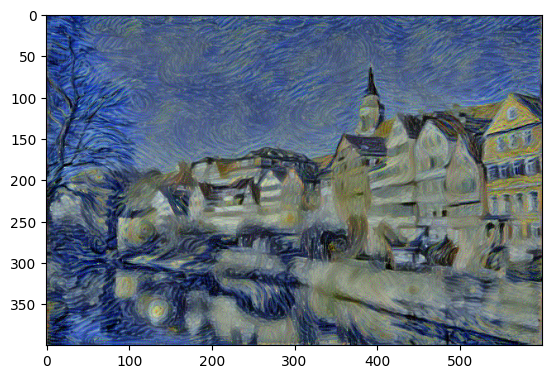

In [266]:
final_img = im_convert(target)
plt.imshow(final_img)

In [268]:
style = load_image('shipwreck.jpeg')
style.shape

torch.Size([1, 3, 400, 600])

In [269]:
style = style.to(device)

style_layers = np.array([0, 5, 10, 19, 28]) + 1
style_features = get_features(style, model, style_layers)

In [270]:
style_grams = {i: gram_matrix(style_features[i]) for i in style_layers}

In [271]:
new_target = torch.randn_like(content).requires_grad_(True).to(device)

In [295]:
content_weight = 1e1
style_weight = 1e4

In [296]:
optimizer = optim.Adam([new_target], lr=1e-4)
progress_bar = tqdm(range(1, 501))
for i in progress_bar:
  optimizer.zero_grad()
  new_target_features = get_features(new_target, model, [1, 6, 11, 13, 20, 29])

  content_loss = torch.mean((new_target_features[13] -
                             content_features[13]) ** 2)

  style_loss = 0
  for layer in style_layers:
    target_feature = new_target_features[layer]
    target_gram = gram_matrix(target_feature)
    _, d, h, w = target_feature.shape
    style_gram = style_grams[layer]
    layer_style_loss = 1/5 * torch.mean(
      (target_gram - style_gram) ** 2)
    style_loss += layer_style_loss / (d * h * w)

    total_loss = content_weight * content_loss + style_weight * style_loss
    total_loss.backward(retain_graph=True)
    optimizer.step()

  if i % 50 == 0:
    print(f'total loss {total_loss}, content_loss, {content_loss}, style_loss, {style_loss}')


 10%|█         | 51/500 [00:10<01:28,  5.07it/s]

total loss 2469.701904296875, content_loss, 10.3538179397583, style_loss, 0.2366163730621338


 20%|██        | 100/500 [00:20<01:21,  4.89it/s]

total loss 2421.091064453125, content_loss, 10.348163604736328, style_loss, 0.23176094889640808


 30%|███       | 150/500 [00:30<01:13,  4.77it/s]

total loss 2356.384765625, content_loss, 10.337903022766113, style_loss, 0.22530056536197662


 40%|████      | 200/500 [00:41<01:01,  4.87it/s]

total loss 2317.10791015625, content_loss, 10.3330717086792, style_loss, 0.22137770056724548


 50%|█████     | 250/500 [00:51<00:50,  4.98it/s]

total loss 2261.58984375, content_loss, 10.332255363464355, style_loss, 0.21582673490047455


 60%|██████    | 301/500 [01:01<00:38,  5.11it/s]

total loss 2231.00537109375, content_loss, 10.331543922424316, style_loss, 0.21276900172233582


 70%|███████   | 351/500 [01:10<00:29,  5.12it/s]

total loss 2180.776611328125, content_loss, 10.334695816040039, style_loss, 0.20774297416210175


 80%|████████  | 401/500 [01:20<00:19,  5.14it/s]

total loss 2150.43896484375, content_loss, 10.338462829589844, style_loss, 0.20470544695854187


 90%|█████████ | 451/500 [01:30<00:09,  5.10it/s]

total loss 2109.084228515625, content_loss, 10.337241172790527, style_loss, 0.2005711942911148


100%|██████████| 500/500 [01:40<00:00,  4.99it/s]

total loss 2087.4814453125, content_loss, 10.347081184387207, style_loss, 0.1984010636806488


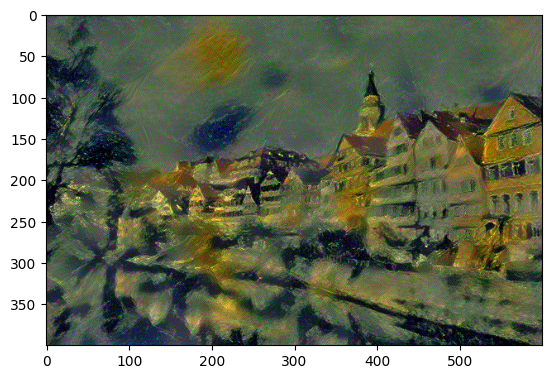

In [297]:
new_final_img = im_convert(new_target)
plt.imshow(new_final_img)